In [13]:
import pandas as pd
import numpy as np

## SALUD

In [ ]:
dir_input = "data/base100/"

salud = pd.read_excel(dir_input+"ipc_subcategorias.xlsx")
salud["Sector"] = "Salud"

len(salud)

vector_w = [0.06142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857] #np.ones(14) / 14


array([0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857])

<Axes: >

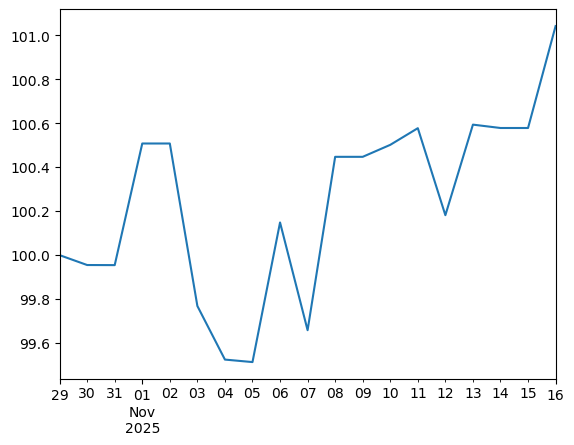

In [23]:

dir_input = "data/base100/"
salud = pd.read_excel(dir_input+"ipc_subcategorias.xlsx")
salud["Sector"] = "Salud"

# --- 1. Extraer columnas de fechas ---
# (todas excepto SUBCATEGORIA y Sector)
cols_fechas = [c for c in salud.columns if "2025" in c]

# --- 2. Pesos iguales ---
n = len(salud)      # debe ser 14
vector_w = np.ones(n) / n

# --- 3. Función de promedio geométrico ponderado ---
def geom_pond(x, w):
    x = np.array(x)
    w = np.array(w)
    return np.exp( np.sum(w * np.log(x)) / np.sum(w) )

# --- 4. Calcular el vector final ponderado ---
vector_final = {}

for col in cols_fechas:
    vector_final[col] = geom_pond(salud[col], vector_w)

# Convertir a Serie ordenada por fecha
vector_final = pd.Series(vector_final)
vector_final.index = pd.to_datetime(vector_final.index)
vector_final = vector_final.sort_index()

vector_final.plot()


## ALIMENTOS 

In [ ]:
w ?

## EDUCACIÓN

## COMBUSTIBLES

## VIVIENDA


## INDICE FINAL